In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [ ]:
labels = os.listdir('/content/drive/MyDrive/train-3')

In [ ]:
labels

['haarcascade_righteye_2splits.xml',
 'haarcascade_frontalface_alt.xml',
 'haarcascade_lefteye_2splits.xml',
 'haarcascade_frontalface_default.xml',
 'haarcascade.xml',
 'yawn',
 'Closed',
 'no_yawn',
 'Open']

In [ ]:
import pandas as pd
import os

dict_info = {}
for i in labels:
  str_ = f'{i}_image_count'
  str_ = 0
  dir_path = f'/content/drive/MyDrive/train-3'
  for path in os.scandir(dir_path):
      if path.is_file():
          str_ += 1
  
  print(f'{i}_image_count :', str_)

haarcascade_righteye_2splits.xml_image_count : 5
haarcascade_frontalface_alt.xml_image_count : 5
haarcascade_lefteye_2splits.xml_image_count : 5
haarcascade_frontalface_default.xml_image_count : 5
haarcascade.xml_image_count : 5
yawn_image_count : 5
Closed_image_count : 5
no_yawn_image_count : 5
Open_image_count : 5


Visualize images randomly

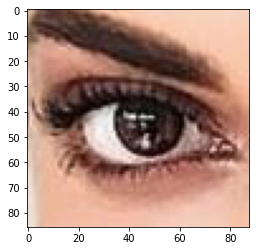

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(f"/content/drive/MyDrive/train-3/Open/_1.jpg"))


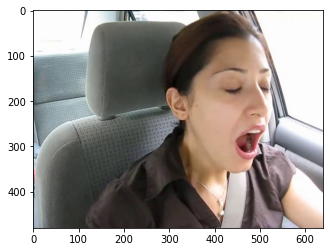

In [ ]:
plt.imshow(plt.imread(f"/content/drive/MyDrive/train-3/yawn/1.jpg"))

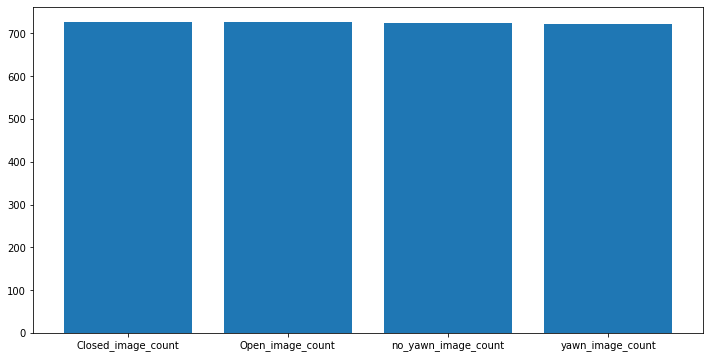

In [ ]:
import matplotlib.pylab as plt

my_dict = { 'Open_image_count': 726, 'Closed_image_count': 726, 'no_yawn_image_count': 725, 'yawn_image_count': 723}

myList = my_dict.items()
myList = sorted(myList) 
x, y = zip(*myList) 
plt.figure(figsize=(12,6))
plt.bar(x,y)
plt.show()

The shape of one image¶

In [ ]:
iii = plt.imread("/content/drive/MyDrive/train-3/yawn/1.jpg")
iii.shape

(480, 640, 3)

Remove the background and only use the face for closed and open eyes

In [ ]:
def get_data(dir_path = "/content/drive/MyDrive/train-3/", face_cas = "/content/drive/MyDrive/train-3/haarcascade_frontalface_default.xml", 
             eye_cas = "/content/drive/MyDrive/train-3/haarcascade.xml"):
    
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    
    for label in labels:
        
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        
        for img in os.listdir(path):
            
            try:
                
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
                
            except Exception as e:
                
                print(e)
                
    return data

In [ ]:
# Get closed and open eyes data
data_train = get_data()

2
3


Remove the background and only use the face for yawn and not yawn.

In [ ]:
def face_for_yawn(direc = "/content/drive/MyDrive/train-3/", 
                  face_cas_path = "/content/drive/MyDrive/train-3/haarcascade_frontalface_default.xml"):
    
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    
    for category in categories:
        
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        
        for image in os.listdir(path_link):
            
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            
            for (x, y, w, h) in faces:
                
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
                
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
def append_data():
    
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    
    return np.array(yaw_no)

In [ ]:
new_data = append_data()

0
1
2
3


<ipython-input-13-776462514064>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


Separate Features-Label¶

In [ ]:
X = []
y = []

for feature, label in new_data:
    
    X.append(feature)
    y.append(label)

Reshape the array

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
y = np.array(y)

TRAIN-TEST SPLIT¶

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)


578

In [ ]:
y_test

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

Import libraries

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras

Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

Baseline Model

In [ ]:

modelb = Sequential()


modelb.add(Conv2D(32, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
modelb.add(MaxPooling2D(2, 2))
modelb.add(Conv2D(16, (3, 3), activation="relu"))
modelb.add(MaxPooling2D(2, 2))
modelb.add(Conv2D(16, (3, 3), activation="relu"))
modelb.add(MaxPooling2D(2, 2))
modelb.add(Flatten())
modelb.add(Dropout(0.5))


modelb.add(Dense(4, activation="relu"))
modelb.add(Dense(4, activation="softmax"))

modelb.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

modelb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [ ]:
history = modelb.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
43/43 [==============================] - 39s 905ms/step - loss: 0.3352 - accuracy: 0.8582 - val_loss: 0.2556 - val_accuracy: 0.8945
Epoch 2/10
43/43 [==============================] - 40s 926ms/step - loss: 0.3045 - accuracy: 0.8686 - val_loss: 0.2430 - val_accuracy: 0.9170
Epoch 3/10
43/43 [==============================] - 47s 1s/step - loss: 0.3122 - accuracy: 0.8634 - val_loss: 0.2386 - val_accuracy: 0.9204
Epoch 4/10
43/43 [==============================] - 44s 1s/step - loss: 0.3020 - accuracy: 0.8760 - val_loss: 0.2409 - val_accuracy: 0.9100
Epoch 5/10
43/43 [==============================] - 47s 1s/step - loss: 0.3015 - accuracy: 0.8790 - val_loss: 0.2427 - val_accuracy: 0.9118
Epoch 6/10
43/43 [==============================] - 40s 920ms/step - loss: 0.2694 - accuracy: 0.8812 - val_loss: 0.2039 - val_accuracy: 0.9360
Epoch 7/10
43/43 [==============================] - 42s 983ms/step - loss: 0.2441 - accuracy: 0.8924 - val_loss: 0.2172 - val_accuracy: 0.9343
Epoch 8/

In [ ]:
preds = modelb.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

19/19 [==============================] - 3s 182ms/step - loss: 22.1908 - accuracy: 0.8858
Loss = 22.190839767456055
Test Accuracy = 0.8858131766319275


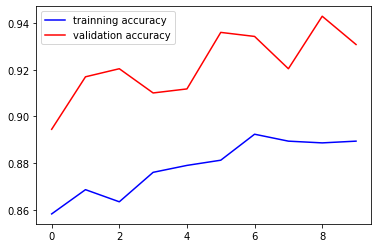

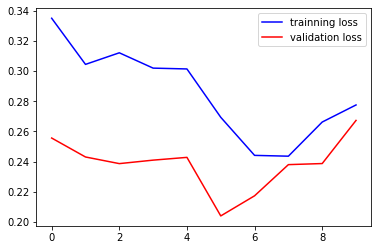

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [ ]:
predictions = (modelb.predict(X_test)).astype("int32")


19/19 [==============================] - 4s 190ms/step


In [ ]:
predictions

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]], dtype=int32)

In [ ]:
accuracy_score(predictions,y_test)
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.01      1.00      0.02         2
           3       0.00      0.00      0.00         0

   micro avg       0.00      1.00      0.01         2
   macro avg       0.00      0.25      0.00         2
weighted avg       0.01      1.00      0.02         2
 samples avg       0.00      0.00      0.00         2



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix(
    y_test.argmax(axis=1), predictions.argmax(axis=1))


array([[ 63,   0,   0,   0],
       [ 74,   0,   0,   0],
       [213,   0,   2,   0],
       [226,   0,   0,   0]])

Using Transfer Learning

In [ ]:
from keras.applications.inception_v3 import InceptionV3

modelt = InceptionV3()

# Initialize the Pretrained Model
feature_extractor = InceptionV3(input_shape=(145, 145, 3),
                             include_top=False)
feature_extractor.trainable = False
#input layer
input_ = tf.keras.Input(shape=(145, 145, 3))
#feature extractor layer
x = feature_extractor(input_, training=False)

#pooling layer
x =keras.layers.GlobalAveragePooling2D()(x)

#final layer with sigmoid activation function
output_ = keras.layers.Dense(4, activation='softmax')(x)

#new model object
modelt = keras.Model(input_, output_)
modelt.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
modelt.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 145, 145, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
history1=modelt.fit(train_generator, epochs=30, validation_data=test_generator)

Epoch 1/30
43/43 [==============================] - 102s 2s/step - loss: 0.1851 - accuracy: 0.8753 - val_loss: 0.1442 - val_accuracy: 0.9187
Epoch 2/30
43/43 [==============================] - 109s 3s/step - loss: 0.1264 - accuracy: 0.9109 - val_loss: 0.1162 - val_accuracy: 0.9308
Epoch 3/30
43/43 [==============================] - 107s 3s/step - loss: 0.1027 - accuracy: 0.9362 - val_loss: 0.1195 - val_accuracy: 0.9066
Epoch 4/30
43/43 [==============================] - 90s 2s/step - loss: 0.0888 - accuracy: 0.9421 - val_loss: 0.0970 - val_accuracy: 0.9308
Epoch 5/30
43/43 [==============================] - 86s 2s/step - loss: 0.0830 - accuracy: 0.9436 - val_loss: 0.1155 - val_accuracy: 0.9031
Epoch 6/30
43/43 [==============================] - 90s 2s/step - loss: 0.0731 - accuracy: 0.9503 - val_loss: 0.0958 - val_accuracy: 0.9273
Epoch 7/30
43/43 [==============================] - 86s 2s/step - loss: 0.0777 - accuracy: 0.9443 - val_loss: 0.1075 - val_accuracy: 0.9100
Epoch 8/30
43/43 

In [ ]:
preds1 = modelt.evaluate(X_test, y_test)
print ("Loss = " + str(preds1[0]))
print ("Test Accuracy = " + str(preds1[1]))

19/19 [==============================] - 25s 1s/step - loss: 44.0694 - accuracy: 0.3945
Loss = 44.06943893432617
Test Accuracy = 0.3944636583328247


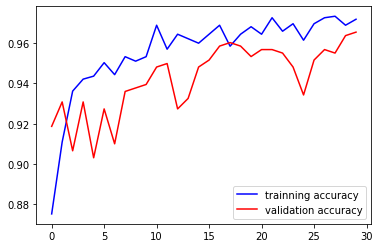

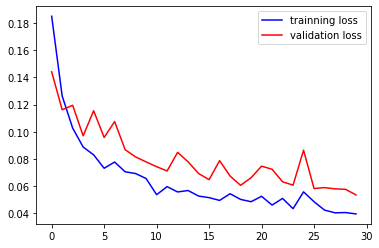

In [ ]:
accuracy1 = history1.history['accuracy']
val_accuracy1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs1 = range(len(accuracy1))

plt.plot(epochs1, accuracy1, "b", label="trainning accuracy")
plt.plot(epochs1, val_accuracy1, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs1, loss1, "b", label="trainning loss")
plt.plot(epochs1, val_loss1, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
predictions1 = (modelt.predict(X_test)).astype("int32")


19/19 [==============================] - 25s 1s/step


In [ ]:
predictions1

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]], dtype=int32)

In [ ]:
accuracy_score(predictions1,y_test)
print(classification_report(predictions1,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.01      1.00      0.02         2
           3       0.00      0.00      0.00         0

   micro avg       0.00      1.00      0.01         2
   macro avg       0.00      0.25      0.00         2
weighted avg       0.01      1.00      0.02         2
 samples avg       0.00      0.00      0.00         2



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix(
    y_test.argmax(axis=1), predictions1.argmax(axis=1))


array([[ 63,   0,   0,   0],
       [ 74,   0,   0,   0],
       [213,   0,   2,   0],
       [226,   0,   0,   0]])

In [ ]:
#MLP
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=[200, 100], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=13, 
                          verbose= True)


In [ ]:
# fit the model
#mlp_model.fit(X_train, y_train)

In [ ]:
MLPClassifier(early_stopping=True, hidden_layer_sizes=[200, 100],
              random_state=13, verbose=True)

In [ ]:
#CNN Model

In [ ]:
model3 = Sequential()
model3.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model3.add(MaxPooling2D(2, 2))
model3.add(Conv2D(128, (3, 3), activation="relu"))
model3.add(MaxPooling2D(2, 2))
model3.add(Conv2D(64, (3, 3), activation="relu"))
model3.add(MaxPooling2D(2, 2))
model3.add(Conv2D(32, (3, 3), activation="relu"))
model3.add(MaxPooling2D(2, 2))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(64, activation="relu"))
model3.add(Dense(4, activation="softmax"))
model3.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_383 (Conv2D)         (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 71, 71, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_384 (Conv2D)         (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 34, 34, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_385 (Conv2D)         (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 64)      

In [ ]:
history3 = model3.fit(train_generator, epochs=40, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/40
43/43 [==============================] - 381s 9s/step - loss: 1.1839 - accuracy: 0.4826 - val_loss: 0.6327 - val_accuracy: 0.7543
Epoch 2/40
43/43 [==============================] - 379s 9s/step - loss: 0.5394 - accuracy: 0.7921 - val_loss: 0.5593 - val_accuracy: 0.7872
Epoch 3/40
43/43 [==============================] - 386s 9s/step - loss: 0.4037 - accuracy: 0.8307 - val_loss: 0.3123 - val_accuracy: 0.8824
Epoch 4/40
43/43 [==============================] - 374s 9s/step - loss: 0.3483 - accuracy: 0.8523 - val_loss: 0.2453 - val_accuracy: 0.9118
Epoch 5/40
43/43 [==============================] - 376s 9s/step - loss: 0.3134 - accuracy: 0.8731 - val_loss: 0.2293 - val_accuracy: 0.9187
Epoch 6/40
43/43 [==============================] - 375s 9s/step - loss: 0.2765 - accuracy: 0.8894 - val_loss: 0.2388 - val_accuracy: 0.9291
Epoch 7/40
43/43 [==============================] - 376s 9s/step - loss: 0.2801 - accuracy: 0.8901 - val_loss: 0.2023 - val_accuracy: 0.9308
Epoch 8/40
43

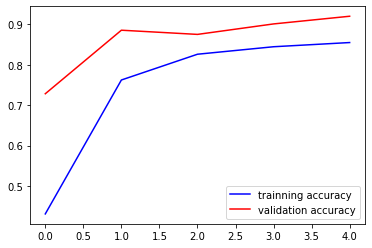

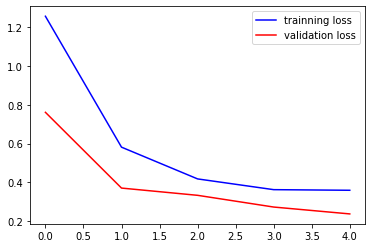

In [ ]:
accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs3 = range(len(accuracy3))

plt.plot(epochs3, accuracy3, "b", label="trainning accuracy")
plt.plot(epochs3, val_accuracy3, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs3, loss3, "b", label="trainning loss")
plt.plot(epochs3, val_loss3, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
predictions3 = (model.predict(X_test)).astype("int32")


In [ ]:
predictions3

In [ ]:
accuracy_score(predictions3,y_test)
print(classification_report(predictions3,y_test))

In [ ]:
confusion_matrix(
    y_test.argmax(axis=1), predictions3.argmax(axis=1))


In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

Prediction


0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/train-3/yawn/104.jpg")])
np.argmax(prediction)

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/train-3/no_yawn/1010.jpg")])
np.argmax(prediction)

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/train-3/Closed/_101.jpg")])
np.argmax(prediction)

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/train-3/Open/_105.jpg")])
np.argmax(prediction)